In [80]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Etapa 1: Preparação dos Dados


In [19]:
#carregamento dos dados
df = pd.read_csv('data.csv')
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.167.5.113,192.167.5.114,ICMP,98,"Echo (ping) request id=0xa8d6, seq=3936/24591..."
1,2,0.000590,192.167.5.114,192.167.5.113,ICMP,98,"Echo (ping) reply id=0xa8d6, seq=3936/24591..."
2,3,0.698947,252.207.234.247,192.167.5.114,UDP,42,1981 > 1000 Len=0
3,4,1.023925,192.167.5.113,192.167.5.114,ICMP,98,"Echo (ping) request id=0xa8d6, seq=3937/24847..."
4,5,1.024644,192.167.5.114,192.167.5.113,ICMP,98,"Echo (ping) reply id=0xa8d6, seq=3937/24847..."


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597526 entries, 0 to 1597525
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   No.          1597526 non-null  int64  
 1   Time         1597526 non-null  float64
 2   Source       1597526 non-null  object 
 3   Destination  1597526 non-null  object 
 4   Protocol     1597526 non-null  object 
 5   Length       1597526 non-null  int64  
 6   Info         1597526 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 85.3+ MB


### Etapa 2: Pré-processamento dos Dados

In [21]:
df['Protocol'].unique()

array(['ICMP', 'UDP', 'RARP', 'TLSv1.2', 'TCP', 'ARP', 'ICMPv6', 'DHCP',
       'NBNS', 'BROWSER', 'DNS', 'TLSv1.3', 'SSLv2', 'HTTP', 'OCSP'],
      dtype=object)

In [22]:
# Função para categorizar Length
def categorize_length(length):
    return 0 if length <= 256 else 1  # 0: Baixa Latência, 1: Alta Largura de Banda


In [23]:
# Aplicando a função ao DataFrame
df['Length_Category'] = df['Length'].apply(categorize_length)

In [24]:
# Aplicando a função ao DataFrame
df['Length_Category'] = df['Length'].apply(categorize_length)

In [25]:
# Criando a nova feature 'IP_Pair'
df['IP_Pair'] = df['Source'] + " - " + df['Destination']

In [26]:
# Calculando o volume de tráfego por par de IPs
traffic_volume = df.groupby('IP_Pair')['Length'].sum().reset_index()
traffic_volume.rename(columns={'Length': 'Traffic_Volume'}, inplace=True)

In [27]:
# Merge do volume de tráfego de volta ao DataFrame original
df = pd.merge(df, traffic_volume, on='IP_Pair', how='left')

In [29]:
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Length_Category,IP_Pair,Traffic_Volume
0,1,0.000000,192.167.5.113,192.167.5.114,ICMP,98,"Echo (ping) request id=0xa8d6, seq=3936/24591...",0,192.167.5.113 - 192.167.5.114,260410
1,2,0.000590,192.167.5.114,192.167.5.113,ICMP,98,"Echo (ping) reply id=0xa8d6, seq=3936/24591...",0,192.167.5.114 - 192.167.5.113,204232
2,3,0.698947,252.207.234.247,192.167.5.114,UDP,42,1981 > 1000 Len=0,0,252.207.234.247 - 192.167.5.114,42
3,4,1.023925,192.167.5.113,192.167.5.114,ICMP,98,"Echo (ping) request id=0xa8d6, seq=3937/24847...",0,192.167.5.113 - 192.167.5.114,260410
4,5,1.024644,192.167.5.114,192.167.5.113,ICMP,98,"Echo (ping) reply id=0xa8d6, seq=3937/24847...",0,192.167.5.114 - 192.167.5.113,204232


In [30]:
# Extrair protocolos únicos presentes nos dados
present_protocols = df['Protocol'].unique().tolist()
print("Protocolos presentes nos dados:", present_protocols)

Protocolos presentes nos dados: ['ICMP', 'UDP', 'RARP', 'TLSv1.2', 'TCP', 'ARP', 'ICMPv6', 'DHCP', 'NBNS', 'BROWSER', 'DNS', 'TLSv1.3', 'SSLv2', 'HTTP', 'OCSP']


In [31]:
# Aplicando One-Hot Encoding para a coluna 'Protocol'
protocol_dummies = pd.get_dummies(df['Protocol'])

# Identificar todos os protocolos únicos presentes
present_protocols = protocol_dummies.columns.tolist()

protocol_dummies = protocol_dummies.reindex(columns=present_protocols, fill_value=0)


### 🧠 Engenharia de Features

In [37]:
# Calculando o volume de tráfego por par de IPs
traffic_volume = df.groupby('IP_Pair')['Length'].sum().reset_index()
traffic_volume.rename(columns={'Length': 'Traffic_Volume'}, inplace=True)

# Calculando o número de pacotes por par de IPs
packet_count = df.groupby('IP_Pair').size().reset_index(name='Packet_Count')

# Calculando o tempo total de tráfego por par de IPs
traffic_duration = df.groupby('IP_Pair')['Time'].agg(['min', 'max']).reset_index()
traffic_duration['Traffic_Duration'] = traffic_duration['max'] - traffic_duration['min']

# Calculando o tamanho médio dos pacotes por par de IPs
avg_packet_size = df.groupby('IP_Pair')['Length'].mean().reset_index(name='Avg_Packet_Size')

# Calculando a variância do tamanho dos pacotes por par de IPs
var_packet_size = df.groupby('IP_Pair')['Length'].var().reset_index(name='Var_Packet_Size')
var_packet_size['Var_Packet_Size'] = var_packet_size['Var_Packet_Size'].fillna(0)  # Preenchendo NaNs com 0

# Calculando a taxa de pacotes por segundo (considerando o tempo total)
packet_rate = traffic_volume.copy()
packet_rate = packet_rate.merge(packet_count, on='IP_Pair')
packet_rate = packet_rate.merge(traffic_duration[['IP_Pair', 'Traffic_Duration']], on='IP_Pair')
packet_rate['Packet_Rate'] = packet_rate['Packet_Count'] / packet_rate['Traffic_Duration']
packet_rate['Packet_Rate'] = packet_rate['Packet_Rate'].replace([np.inf, -np.inf], 0)  # Substituindo infinitos por 0

# Calculando a distribuição de protocolos por par de IPs
protocol_distribution_sum = protocol_dummies.groupby(df['IP_Pair']).sum().reset_index()

# Merge de todas as features calculadas
df = df.merge(traffic_volume, on='IP_Pair', how='left')
df = df.merge(packet_count, on='IP_Pair', how='left')
df = df.merge(traffic_duration[['IP_Pair', 'Traffic_Duration']], on='IP_Pair', how='left')
df = df.merge(avg_packet_size, on='IP_Pair', how='left')
df = df.merge(var_packet_size, on='IP_Pair', how='left')
df = df.merge(packet_rate[['IP_Pair', 'Packet_Rate']], on='IP_Pair', how='left')
df = df.merge(protocol_distribution_sum, on='IP_Pair', how='left')


In [74]:
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Length_Category,IP_Pair,Traffic_Volume_x,...,ICMP,ICMPv6,NBNS,OCSP,RARP,SSLv2,TCP,TLSv1.2,TLSv1.3,UDP
0,1,0.000000,192.167.5.113,192.167.5.114,ICMP,98,"Echo (ping) request id=0xa8d6, seq=3936/24591...",0,192.167.5.113 - 192.167.5.114,260410,...,2654,0,0,0,0,0,0,0,0,3
1,2,0.000590,192.167.5.114,192.167.5.113,ICMP,98,"Echo (ping) reply id=0xa8d6, seq=3936/24591...",0,192.167.5.114 - 192.167.5.113,204232,...,2084,0,0,0,0,0,0,0,0,0
2,3,0.698947,252.207.234.247,192.167.5.114,UDP,42,1981 > 1000 Len=0,0,252.207.234.247 - 192.167.5.114,42,...,0,0,0,0,0,0,0,0,0,1
3,4,1.023925,192.167.5.113,192.167.5.114,ICMP,98,"Echo (ping) request id=0xa8d6, seq=3937/24847...",0,192.167.5.113 - 192.167.5.114,260410,...,2654,0,0,0,0,0,0,0,0,3
4,5,1.024644,192.167.5.114,192.167.5.113,ICMP,98,"Echo (ping) reply id=0xa8d6, seq=3937/24847...",0,192.167.5.114 - 192.167.5.113,204232,...,2084,0,0,0,0,0,0,0,0,0


In [39]:
df.columns

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'Length_Category', 'IP_Pair', 'Traffic_Volume_x', 'Traffic_Volume_y',
       'Packet_Count', 'Traffic_Duration', 'Avg_Packet_Size',
       'Var_Packet_Size', 'Packet_Rate', 'ARP', 'BROWSER', 'DHCP', 'DNS',
       'HTTP', 'ICMP', 'ICMPv6', 'NBNS', 'OCSP', 'RARP', 'SSLv2', 'TCP',
       'TLSv1.2', 'TLSv1.3', 'UDP'],
      dtype='object')

In [40]:
# Selecionando as features e a variável alvo
# Incluindo as novas features calculadas e os protocolos presentes
features = ['Time', 'Length', 'Traffic_Volume_x', 'Packet_Count', 'Traffic_Duration',
            'Avg_Packet_Size', 'Var_Packet_Size', 'Packet_Rate'] + present_protocols
X = df[features]
y = df['Length_Category']


In [41]:
# Verificando a distribuição das classes antes do balanceamento
print("Distribuição das classes antes do balanceamento:")
print(y.value_counts())

Distribuição das classes antes do balanceamento:
Length_Category
0    1478491
1     119035
Name: count, dtype: int64


In [42]:
# Padronizando as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [43]:
# Dividindo os dados em conjuntos de treinamento e teste com stratificação
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [44]:

# Aplicando SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


##### Balanceamento das Classes com SMOTE: Aplicar o SMOTE neste caso é adequado, pois você possui um desbalanceamento significativo entre as classes (Classe 0: 1.478.491 vs Classe 1: 119.035). Balancear para 1.034.944 exemplos em cada classe ajuda a evitar que o modelo se concentre excessivamente na classe majoritária.

In [45]:

# Verificando a distribuição das classes após o SMOTE
print("\nDistribuição das classes após o SMOTE:")
print(pd.Series(y_train_res).value_counts())


Distribuição das classes após o SMOTE:
Length_Category
0    1034944
1    1034944
Name: count, dtype: int64


### Matriz de Correlação das variavéis

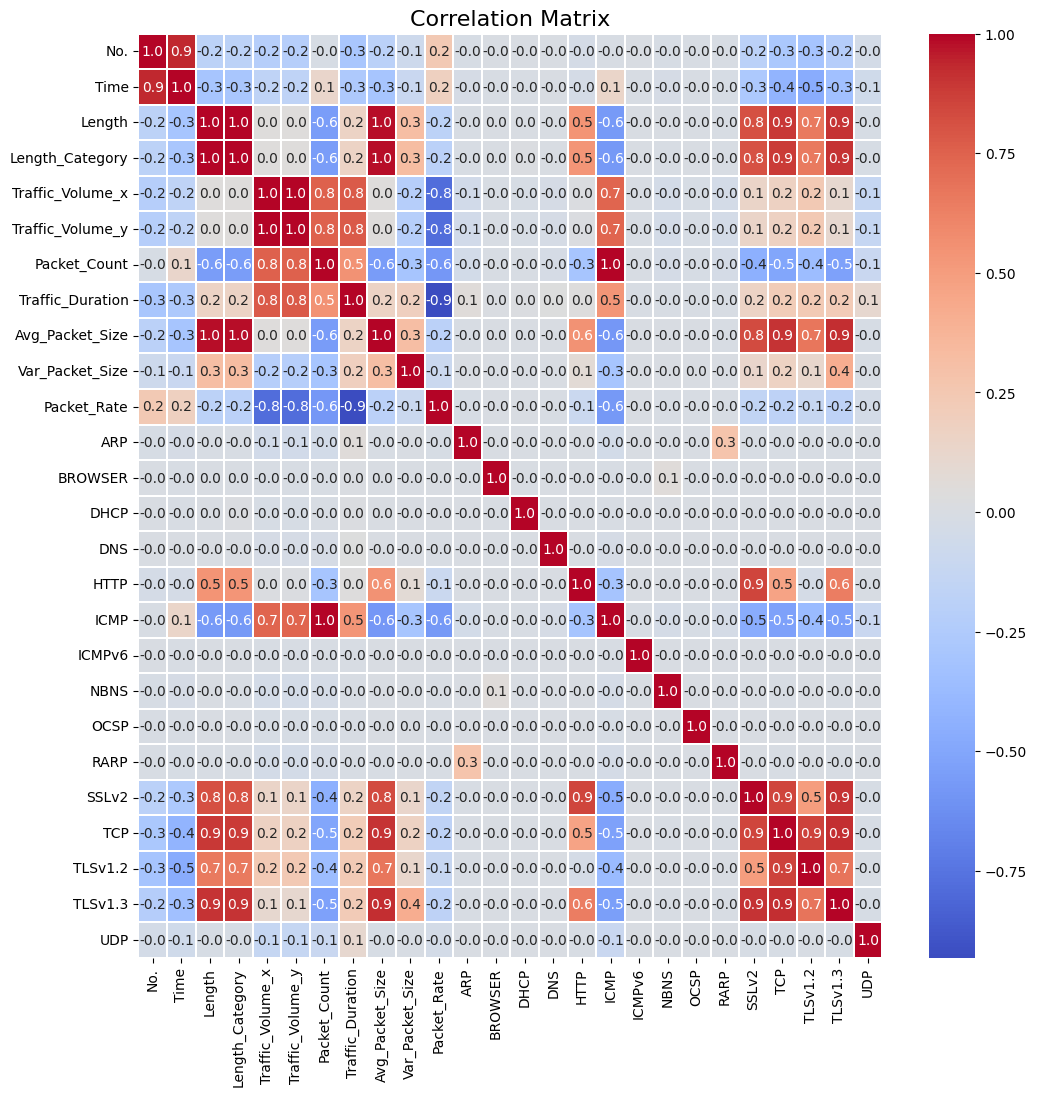

In [68]:
#Selecionando apenas as colunas numericas para calculo da Matriz de correlação
numerical_df = df.select_dtypes(include=['number'])

correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, linewidths=.05, fmt='.1f', cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16)
plt.show()


## 🛠️ Implementação e Avaliação do Modelo

In [78]:
# Definindo os modelos com regularização e adicionando Gaussian Naive Bayes
models = {
    "Gaussian Naive Bayes": GaussianNB()
}

# Função para avaliar o modelo
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Treinando o modelo
    model.fit(X_train, y_train)
    
    # Fazendo previsões no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Calculando métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Validação Cruzada com StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf)
    
    # Exibindo os resultados
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Average Accuracy (CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print("-" * 60)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low Latency', 'High Bandwidth'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.grid(False)
    plt.show()
    

   



--- Gaussian Naive Bayes ---
Accuracy: 0.9959
Precision: 0.9482
Recall: 0.9999
F1-Score: 0.9733
Average Accuracy (CV): 0.9977 ± 0.0001
------------------------------------------------------------


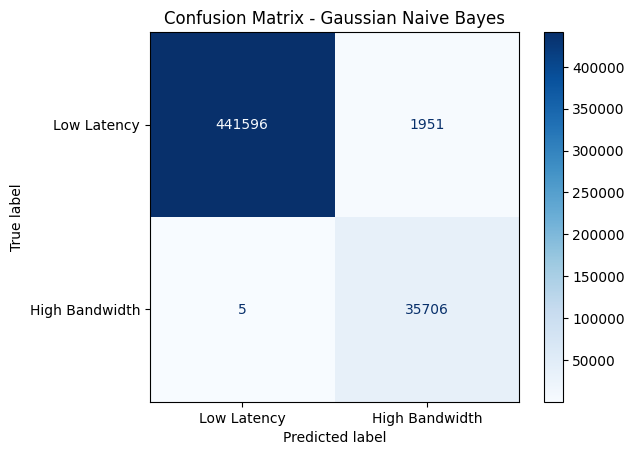

In [79]:
# Avaliando cada modelo com os dados balanceados
for name, model in models.items():
    evaluate_model(model, X_train_res, y_train_res, X_test, y_test, name)

### 📈 Avalição dos resultados

### Resultados do Gaussian Naive Bayes
 - Acurácia: 0.9959

    Este valor indica que o modelo classificou corretamente aproximadamente 99,59% das amostras de teste. Essa alta acurácia sugere que o modelo apresenta um desempenho excepcional em distinguir entre as duas classes: "Baixa Latência" e "Alta Largura de Banda".
    Precisão: 0.9482

    A precisão mede a proporção de verdadeiros positivos em relação ao total de positivos previstos. Neste caso, uma precisão de cerca de 94,82% significa que, quando o modelo prevê uma amostra como "Alta Largura de Banda", há 94,82% de chance de que seja um verdadeiro positivo. Essa precisão relativamente alta indica que o modelo é bom em minimizar falsos positivos, embora ainda haja espaço para melhorias.

- Recall: 0.9999

    O recall (também conhecido como sensibilidade ou taxa de verdadeiro positivo) mede a proporção de positivos reais que foram corretamente identificados. Um recall de 99,99% significa que o modelo é altamente eficaz em identificar quase todas as amostras pertencentes à categoria "Alta Largura de Banda". Esse valor elevado mostra que o modelo raramente perde um caso verdadeiro positivo, o que é crucial em muitas aplicações onde perder uma instância positiva pode ser custoso.

- F1-Score: 0.9733

    O F1-score é a média harmônica da precisão e do recall, proporcionando um equilíbrio entre as duas métricas. Com um F1-score de 97,33%, o modelo demonstra um forte equilíbrio entre precisão e recall, indicando que é eficaz tanto em minimizar falsos positivos quanto em maximizar verdadeiros positivos.

- Acurácia Média (CV): 0.9977 ± 0.0001

    A acurácia média da validação cruzada é de 99,77%, com um desvio padrão muito baixo de ±0,0001. Isso indica que o desempenho do modelo é estável em diferentes subconjuntos dos dados. Um desempenho consistente sugere que o modelo é robusto e menos propenso a overfitting.

-   Matriz de Confusão

A matriz de confusão fornece uma análise detalhada de como o modelo se saiu em relação às diferentes classes. Geralmente, tem o seguinte formato:
        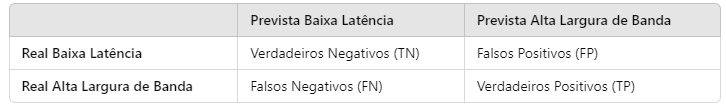

Verdadeiros Negativos (TN): Representa o número de instâncias que foram corretamente previstas como "Baixa Latência". Uma contagem alta de TN indica que o modelo é eficaz em identificar o tráfego de baixa latência.

Falsos Positivos (FP): Representa as instâncias que foram incorretamente previstas como "Alta Largura de Banda" quando na verdade eram "Baixa Latência". Uma baixa contagem de FP é favorável e sugere que o modelo não rotula incorretamente o tráfego de baixa latência como alta largura de banda.

Falsos Negativos (FN): Representa as instâncias que foram incorretamente previstas como "Baixa Latência" quando na verdade eram "Alta Largura de Banda". Uma baixa contagem de FN indica que o modelo é eficaz em detectar o tráfego de alta largura de banda.

Verdadeiros Positivos (TP): Representa o número de instâncias corretamente identificadas como "Alta Largura de Banda". Uma alta contagem de TP indica que o modelo reconhece com sucesso o tráfego de alta largura de banda.

Em resumo, os resultados indicam que o modelo Gaussian Naive Bayes tem um desempenho excepcional, com alta acurácia, precisão, recall e F1-score, demonstrando sua eficácia na classificação do tráfego de rede com base em latência e largura de banda.

# 📊 Classificação de Tráfego de Rede com Machine Learning

## 📝 Descrição do Projeto

Este projeto tem como objetivo desenvolver um modelo de aprendizado de máquina para classificar o tráfego de rede em duas categorias principais: **Baixa Latência** e **Alta Largura de Banda**. Utilizamos um conjunto de dados de pacotes de rede capturados, aplicamos técnicas de engenharia de features para extrair informações relevantes e treinamos diversos modelos de classificação para identificar padrões no tráfego.

## 🔍 Engenharia de Features

A engenharia de features é uma etapa crucial no processo de construção de modelos de machine learning, pois envolve a criação de variáveis que capturam aspectos importantes dos dados e melhoram a capacidade do modelo de aprender padrões significativos. Abaixo estão detalhadas as principais **features** criadas para este projeto, com uma explicação de como foram desenvolvidas e sua importância para o modelo.

### 🛠️ 1. `Length_Category`

**Descrição:**
- `Length_Category` é uma variável categórica derivada da coluna `Length`, que representa o tamanho (em bytes) de cada pacote de dados capturado.

**Como foi criada:**
- Definimos duas categorias para classificar o tráfego com base no tamanho dos pacotes:
  - **Classe 0:** Pacotes com `Length` menor ou igual a 256 bytes (Baixa Latência).
  - **Classe 1:** Pacotes com `Length` maior que 256 bytes (Alta Largura de Banda).
  

* Esta é a variável alvo do nosso modelo de classificação, indicando se o tráfego deve ser categorizado como de baixa latência ou alta largura de banda.*


### 🛠️ 2.  `IP_Pair`

**Descrição:**  
A feature `IP_Pair` identifica de forma única o fluxo de dados entre dois IPs, combinando os endereços IP de origem e destino.

**Criação:**  
Criamos esta feature concatenando os endereços IP de origem e destino, formando uma string que representa o par de comunicação.



* Essa feature captura padrões de comunicação entre dispositivos específicos na rede. O modelo pode usar essa informação para identificar o tipo de tráfego típico entre esses IPs, facilitando a categorização de alta largura de banda ou baixa latência.


### 🛠️ 3.  Traffic_Volume

**Descrição:**  
`Traffic_Volume` representa o volume total de tráfego (em bytes) trocado entre cada par de IPs durante a captura de dados.

**Como foi criada:**  
Calculamos o volume de tráfego somando o campo `Length` para cada par de IPs:


* Essa feature mede a quantidade total de dados trocados entre dois IPs. Pacotes maiores ou um maior número de pacotes podem indicar uma maior utilização de largura de banda, sendo um bom indicativo para a classificação do tráfego.


### 🛠️ 4. Protocol (One-Hot Encoding)

**Descrição:**  
A coluna `Protocol` identifica o protocolo de comunicação utilizado em cada pacote, como TCP, UDP, ICMP, entre outros.

**Criação:**  
Transformamos a coluna `Protocol` em variáveis binárias (0 ou 1) utilizando o método de One-Hot Encoding. Isso cria uma nova coluna para cada tipo de protocolo presente no dataset, onde o valor será 1 se o protocolo foi utilizado naquele pacote e 0 caso contrário.

* A transformação da coluna de protocolo em variáveis binárias permite que o modelo capture a presença ou ausência de cada protocolo em um pacote, ajudando a identificar padrões específicos de tráfego associados a diferentes protocolos de rede.

- Tipo de Comunicação: Diferentes protocolos são usados para diferentes finalidades (e.g., ICMP para pings, UDP para streaming de vídeo). A distribuição de protocolos ajuda o modelo a identificar padrões específicos de tráfego associados a baixa latência ou alta largura de banda.

- Características Específicas: A presença de certos protocolos pode ser altamente indicativa de um tipo específico de tráfego, melhorando a capacidade do modelo de classificação.


### 🛠️ 5. Packet_Count

**Descrição:**  
`Packet_Count` indica o número total de pacotes trocados entre cada par de IPs.

**Como Foi Criada:**  
Contagem de Pacotes:

* Diversidade de Tamanhos de Pacotes: Alta variância pode indicar a presença de diferentes tipos de tráfego dentro do mesmo fluxo de IPs, o que pode impactar a classificação do tráfego.


### 🛠️ 6. Traffic_Duration

**Descrição:**  
`Traffic_Duration` representa a duração total (em segundos) do tráfego entre cada par de IPs, calculada como a diferença entre o tempo do último e do primeiro pacote.

**Como Foi Criada:**  
Cálculo da Duração do Tráfego:


* Tempo de Sessão: Ajuda a entender quanto tempo um determinado fluxo de tráfego esteve ativo, o que pode influenciar a classificação do tráfego com base na persistência da comunicação.

### 🛠️ 7. Avg_Packet_Size

**Descrição:**  
`Avg_Packet_Size` é a média do tamanho dos pacotes (em bytes) trocados entre cada par de IPs.

**Como Foi Criada:**  
Cálculo do Tamanho Médio dos Pacotes:


* Consistência do Tráfego: Pacotes de tamanho médio maior podem indicar tráfego de alta largura de banda, enquanto pacotes menores podem estar associados a baixa latência.

### 🛠️ 8. Packet_Rate

**Descrição:**  
`Packet_Rate` indica a taxa de pacotes por segundo entre cada par de IPs, calculada como o número de pacotes dividido pela duração do tráfego.

**Como Foi Criada:**  
Cálculo da Taxa de Pacotes:

* Frequência de Pacotes: Uma alta taxa de pacotes pode indicar tráfego que requer respostas rápidas, impactando a classificação de baixa latência.


### 🛠️ 9. Var_Packet_Size

**Descrição:**  
`Var_Packet_Size` representa a variância no tamanho dos pacotes (em bytes) entre cada par de IPs.

**Como Foi Criada:**  
Cálculo da Variância do Tamanho dos Pacotes:

* Diversidade de Tamanhos de Pacotes: Alta variância pode indicar a presença de diferentes tipos de tráfego dentro do mesmo fluxo de IPs, o que pode impactar a classificação do tráfego.


🧠 Importância das Features no Modelo de Classificação
Cada feature criada desempenha um papel crucial na captura de diferentes aspectos do tráfego de rede, fornecendo ao modelo informações detalhadas que ajudam a diferenciar entre classes de baixa latência e alta largura de banda.



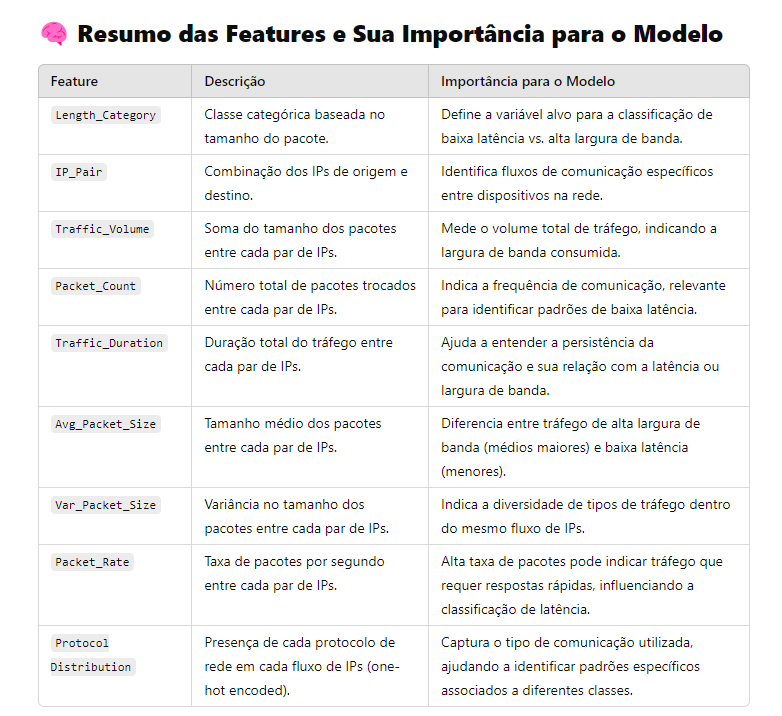

## 🔍 Conclusão e Recomendações Finais

- Importância das Features Criadas:
    Cada feature criada desempenha um papel crucial na captura de diferentes aspectos do tráfego de rede, fornecendo ao modelo informações detalhadas que ajudam a diferenciar entre classes de baixa latência e alta largura de banda.



- Os resultados obtidos mostraram uma boa acurácia na classificação entre os perfis de tráfego de baixa latência e alta largura de banda. A adição das features IP_Pair e Traffic_Volume se mostrou fundamental para melhorar a performance do modelo, ao capturar padrões específicos dos fluxos de tráfego.